In [16]:
import numpy as np

REFERENCE_MEASUREMENTS_MA = np.array(
    [20.00, 18.01, 15.98, 13.99, 12.01, 10.04, 8.03, 5.96, 3.98]
)
ANALOGMOD_MEASUREMENTS_MA = np.array(
    [20.13, 18.09, 16.04, 13.92, 11.87, 9.94, 7.81, 5.79, 3.76]
)


def ref_readings_with_uncertainty(readings: np.ndarray, k: float = 1.0) -> np.ndarray:
    """
    Return a (N,2) array with columns: (reading [mA,] uncertainty [mA]).
    Specs:
      - 0 - 20.99 mA: resolution = 0.01 mA, accuracy = 0.2% + 5 counts
      - 21 - 100 mA:   resolution = 0.1  mA, accuracy = 1%   + 5 counts
    The percentage and counts terms are converted to standard uncertainties assuming
    rectangular distributions (divide by sqrt(3)). The result is scaled by k:
      k=1 -> standard uncertainty, k≈2 -> approx 95% expanded uncertainty.
    """
    readings = np.asarray(readings, dtype=float)
    mask_low = readings <= 20.99

    # per-range parameters
    resolution = np.where(mask_low, 0.01, 0.1)
    accuracy_pct = np.where(mask_low, 0.002, 0.01)  # fraction (0.2% -> 0.002)
    counts = 5.0

    # standard uncertainties for each component (rectangular -> divide by sqrt(3))
    u_pct = (accuracy_pct * np.abs(readings)) / np.sqrt(3)
    u_counts = (counts * resolution) / np.sqrt(3)

    # combined standard uncertainty
    u_combined = np.sqrt(u_pct**2 + u_counts**2)

    # apply coverage factor k and return paired matrix
    return np.column_stack((readings, u_combined * k))


def mod_readings_with_uncertainty(readings: np.ndarray, k: float = 1.0) -> np.ndarray:
    """
    Return a (N,2) array with columns: (reading [mA], uncertainty [mA]).
    Specs:
      - "Current Terminal: 0.2% full scale at 25 °C"
      - assume full scale FS = 20.0 mA and resolution = 0.01 mA
    The 0.2% term is treated as a rectangular distribution (divide by sqrt(3))
    and combined in quadrature with the resolution uncertainty. Result scaled by k.
    """
    readings = np.asarray(readings, dtype=float)

    FS = 20.0  # mA full scale
    accuracy_fs = 0.002  # 0.2% -> fraction
    resolution = 0.01  # mA (assumed from measurement precision)

    # standard uncertainties (rectangular distributions)
    u_fs = (accuracy_fs * FS) / np.sqrt(3)
    u_res = resolution / np.sqrt(3)

    u_combined = np.sqrt(u_fs**2 + u_res**2)

    return np.column_stack((readings, u_combined * k * np.ones_like(readings)))


REFERENCE_MEASUREMENTS_MA_U = ref_readings_with_uncertainty(
    REFERENCE_MEASUREMENTS_MA, k=1.0
)
ANALOGMOD_MEASUREMENTS_MA_U = mod_readings_with_uncertainty(
    ANALOGMOD_MEASUREMENTS_MA, k=1.0
)

print("Referência com incertezas (mA):")
print(REFERENCE_MEASUREMENTS_MA_U)

print("Cartão com incertezas (mA):")
print(ANALOGMOD_MEASUREMENTS_MA_U)

Referência com incertezas (mA):
[[20.          0.03696846]
 [18.01        0.03557827]
 [15.98        0.03426097]
 [13.99        0.03308011]
 [12.01        0.03202582]
 [10.04        0.03110845]
 [ 8.03        0.03032009]
 [ 5.96        0.02967651]
 [ 3.98        0.02923104]]
Cartão com incertezas (mA):
[[20.13        0.02380476]
 [18.09        0.02380476]
 [16.04        0.02380476]
 [13.92        0.02380476]
 [11.87        0.02380476]
 [ 9.94        0.02380476]
 [ 7.81        0.02380476]
 [ 5.79        0.02380476]
 [ 3.76        0.02380476]]


In [18]:
from scipy.odr import ODR, Model, RealData


def lin_fit(X: np.ndarray, Y: np.ndarray):
    """
    Perform a linear fit Y = a*X + b taking into account uncertainties in both X and Y.
    X and Y should be (N,2) arrays with columns: (value, standard uncertainty).
    """

    # Extract values and uncertainties
    x_vals = X[:, 0]
    x_errs = X[:, 1]
    y_vals = Y[:, 0]
    y_errs = Y[:, 1]

    # Define linear model function
    def linear_func(params, x):
        a, b = params
        return a * x + b

    # Create ODR objects
    model = Model(linear_func)
    data = RealData(x_vals, y_vals, sx=x_errs, sy=y_errs)
    odr = ODR(data, model, beta0=[1.0, 0.0])  # initial guess for [slope, intercept]

    # Run the regression
    output = odr.run()

    # Extract results
    slope, intercept = output.beta
    slope_err, intercept_err = output.sd_beta

    return {
        "slope": slope,
        "intercept": intercept,
        "slope_uncertainty": slope_err,
        "intercept_uncertainty": intercept_err,
        "output": output,
    }


linear_fit = lin_fit(REFERENCE_MEASUREMENTS_MA_U, ANALOGMOD_MEASUREMENTS_MA_U)
a, b, da, db = (
    linear_fit["slope"],
    linear_fit["intercept"],
    linear_fit["slope_uncertainty"],
    linear_fit["intercept_uncertainty"],
)

print(f"Ajuste linear: a = {a:.6f} ± {da:.6f}, b = {b:.6f} ± {db:.6f}")

Ajuste linear: a = 1.022430 ± 0.003074, b = -0.341848 ± 0.038638


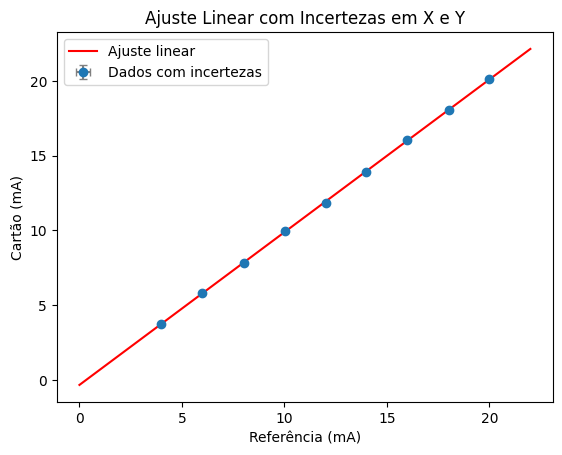

In [20]:
import matplotlib.pyplot as plt

# Plot data with error bars
plt.errorbar(
    REFERENCE_MEASUREMENTS_MA_U[:, 0],
    ANALOGMOD_MEASUREMENTS_MA_U[:, 0],
    xerr=REFERENCE_MEASUREMENTS_MA_U[:, 1],
    yerr=ANALOGMOD_MEASUREMENTS_MA_U[:, 1],
    fmt="o",
    label="Dados com incertezas",
    ecolor="gray",
    capsize=3,
)

# Plot fitted line
x_fit = np.linspace(0, 22, 100)
y_fit = a * x_fit + b
plt.plot(x_fit, y_fit, "r-", label="Ajuste linear")

plt.xlabel("Referência (mA)")
plt.ylabel("Cartão (mA)")
plt.title("Ajuste Linear com Incertezas em X e Y")
plt.legend()
plt.show()